In [18]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [19]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [20]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [21]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

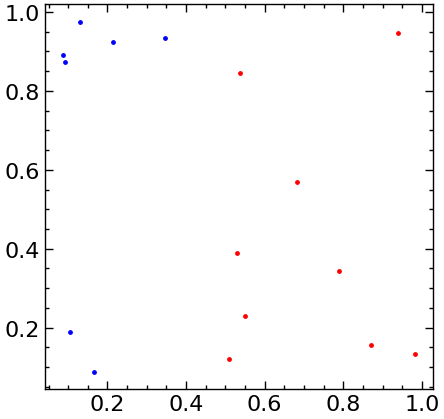

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [23]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [24]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [25]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.5283, 0.9829],
        [0.5283, 0.3466],
        [0.5283, 0.0864],
        [0.5283, 0.7888],
        [0.5283, 0.1034],
        [0.5283, 0.2142],
        [0.5283, 0.0919],
        [0.5283, 0.5498],
        [0.5283, 0.8699],
        [0.5283, 0.6813],
        [0.5283, 0.5383],
        [0.5283, 0.9382],
        [0.5283, 0.1652],
        [0.5283, 0.1301],
        [0.5283, 0.5084],
        [0.9829, 0.3466],
        [0.9829, 0.0864],
        [0.9829, 0.7888],
        [0.9829, 0.1034],
        [0.9829, 0.2142],
        [0.9829, 0.0919],
        [0.9829, 0.5498],
        [0.9829, 0.8699],
        [0.9829, 0.6813],
        [0.9829, 0.5383],
        [0.9829, 0.9382],
        [0.9829, 0.1652],
        [0.9829, 0.1301],
        [0.9829, 0.5084],
        [0.3466, 0.0864],
        [0.3466, 0.7888],
        [0.3466, 0.1034],
        [0.3466, 0.2142],
        [0.3466, 0.0919],
        [0.3466, 0.5498],
        [0.3466, 0.8699],
        [0.3466, 0.6813],
        [0.3466, 0.5383],
        [0.3

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [26]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.4546, -0.1817, -0.4419,  0.2605, -0.4249, -0.3141, -0.4364,  0.0215,
         0.3416,  0.1530,  0.0100,  0.4099, -0.3631, -0.3983, -0.0199, -0.6362,
        -0.8965, -0.1941, -0.8795, -0.7686, -0.8910, -0.4331, -0.1130, -0.3016,
        -0.4446, -0.0447, -0.8177, -0.8528, -0.4744, -0.2603,  0.4421, -0.2432,
        -0.1324, -0.2547,  0.2032,  0.5233,  0.3347,  0.1917,  0.5915, -0.1814,
        -0.2166,  0.1618,  0.7024,  0.0170,  0.1279,  0.0055,  0.4634,  0.7835,
         0.5949,  0.4519,  0.8518,  0.0788,  0.0437,  0.4221, -0.6854, -0.5745,
        -0.6968, -0.2390,  0.0811, -0.1075, -0.2505,  0.1494, -0.6235, -0.6587,
        -0.2803,  0.1109, -0.0115,  0.4464,  0.7665,  0.5779,  0.4349,  0.8348,
         0.0618,  0.0267,  0.4051, -0.1223,  0.3356,  0.6557,  0.4671,  0.3241,
         0.7239, -0.0490, -0.0842,  0.2942,  0.4579,  0.7780,  0.5894,  0.4464,
         0.8462,  0.0733,  0.0381,  0.4165,  0.3201,  0.1315, -0.0115,  0.3884,
        -0.3846, -0.4197, -0.0414, -0.18

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [27]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.5219, 0.5743, 0.6695, 0.2645, 0.4693, 0.6221, 0.6528, 0.1598, 0.4134,
        0.2376, 0.4574, 0.6919, 0.4710, 0.7097, 0.2690, 1.0231, 1.1748, 0.2863,
        0.8814, 1.1046, 1.1594, 0.4440, 0.1154, 0.5319, 0.8408, 0.8151, 0.8188,
        1.1997, 0.4746, 0.2636, 0.7378, 0.7827, 0.1326, 0.2615, 0.7319, 0.9372,
        0.4937, 0.2107, 0.5917, 0.8640, 0.2207, 0.8290, 0.8913, 0.7022, 0.1323,
        0.0183, 0.8074, 1.0748, 0.6760, 0.4542, 0.8535, 0.8067, 0.0952, 0.8791,
        0.7023, 0.8184, 0.8763, 0.2641, 0.2038, 0.2518, 0.5621, 0.6216, 0.6733,
        0.9138, 0.3578, 0.7444, 0.6847, 0.4483, 0.7672, 0.6922, 0.7874, 1.1266,
        0.1183, 0.7871, 0.4109, 0.1327, 0.7720, 1.0112, 0.5868, 0.3337, 0.7242,
        0.8384, 0.0981, 0.8573, 0.7900, 1.0588, 0.6630, 0.4473, 0.8493, 0.7889,
        0.1089, 0.8611, 0.3287, 0.3647, 0.6157, 0.8144, 0.4098, 0.8558, 0.1174,
        0.4555, 0.7656, 0.7932, 0.7079, 1.1046, 0.3632, 0.3104, 0.4551, 0.7060,
        0.6844, 0.4821, 0.4122, 0.8442, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [28]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 1,  9],
        [ 3,  7],
        [ 3, 14],
        [ 5, 13],
        [ 6, 14],
        [ 7, 14],
        [ 8, 15]], device='cuda:0')

We will call all the particles in the left column "1" and the right column "2"

In [29]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [30]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [31]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [32]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

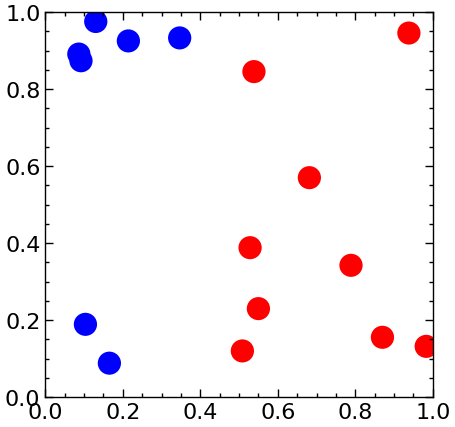

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

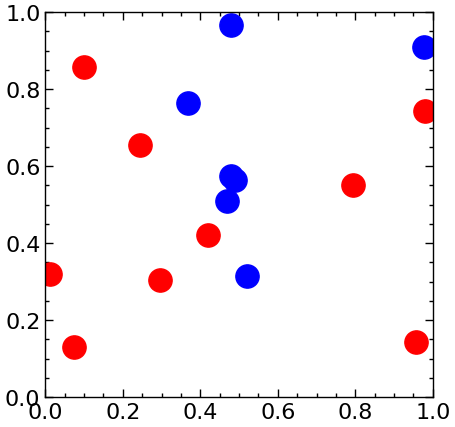

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50, blit=True)
ani.save(filename='ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

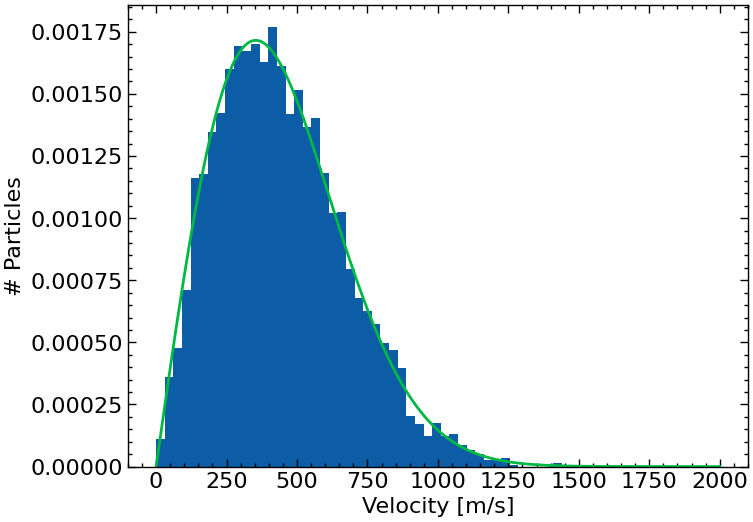

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

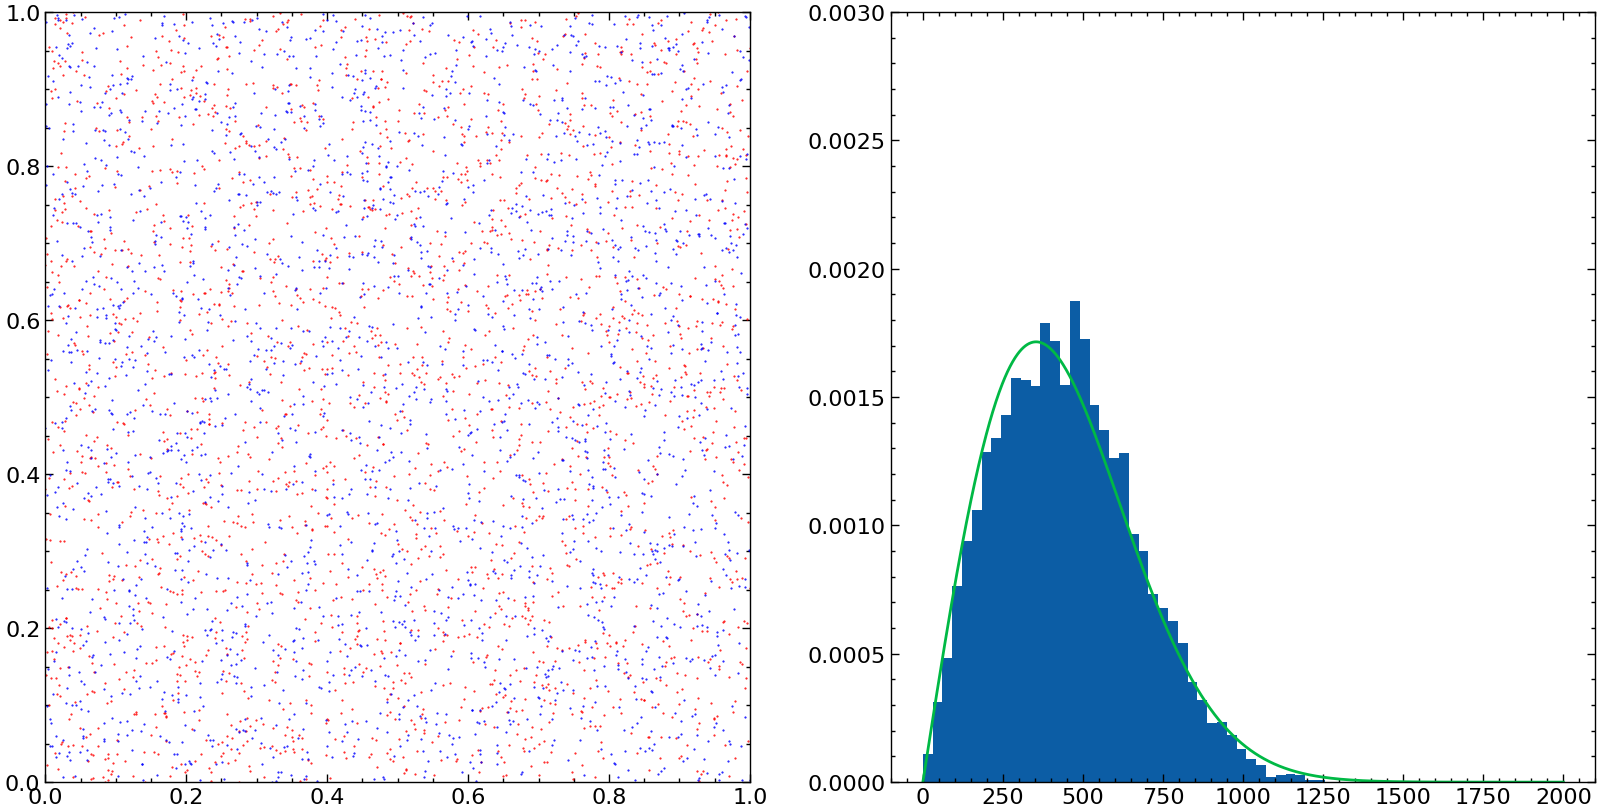

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)